In [1]:
#pip install spacerocks

In [1]:
cd /home/jiamingp

/home/jiamingp


In [3]:
from spacerocks import SpaceRock
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy.time import Time
import astropy.units as u
import numpy as np
from astropy.time import Time
from astropy.coordinates import SkyCoord
import astropy.units as u
import easyaccess as ea
import matplotlib.pyplot as plt
from DEEP_pointings import DEEP_fields_2019, DEEP_fields_2020
from compute_chip import compute_chip

ImportError: cannot import name 'SpaceRock' from 'spacerocks' (unknown location)

In [16]:
#dfo = pd.read_json('https://minorplanetcenter.net/Extended_Files/mpcorb_extended.json.gz')
#dfo.to_csv('mpcorb_extended.csv', index=None)
dfo = pd.read_csv('mpcorb_extended.csv')

In [17]:
df = dfo.loc[dfo.Orbit_type=="Jupiter Trojan"]
df.to_csv('mpcorb_JT.csv', index=None)
print(len(df))

10437


In [11]:
from matplotlib.patches import Ellipse

class DECamField(object):
#
    def __init__(self, pos):
        self.ra = pos.ra.deg
        self.dec = pos.dec.deg

    def ellipse(self):
        # An approximation to the DECam field of view, suitable e.g. for plotting
        semimajor_deg = 1.08
        semiminor_deg = 0.98
        center = (self.ra, self.dec)
        rotation = 0
        return Ellipse(center, 2*semimajor_deg, 2*semiminor_deg, rotation, fill=False, ec='k')
    
    def contains(self, ra1, dec1):
        # returns True if the point (ra1, dec1) lies inside the field
        radiff = ra1-self.ra
        if radiff > 360: radiff -= 2*360
        return radiff**2/1.08**2 + (dec1-self.dec)**2/0.98**2 <= 1.0

In [5]:
def give_ccd(date,expnum,pointings):
    df = dfo.loc[dfo.Orbit_type=="Jupiter Trojan"]
    rocks = SpaceRock(a=df.a.values, 
                  e=df.e.values, 
                  inc=df.i.values, 
                  arg=df.Peri.values, 
                  node=df.Node.values, 
                  t_peri=df.Tp.values, 
                  epoch=df.Epoch.values,
                  H=df.H.values, 
                  name=df.Principal_desig.values.astype(str),
                  precise=False,
                  coordinates='keplerian',
                  angles='degrees',
                  frame='heliocentric',
                  obscode='W84')
    dates = Time(date, format='iso', scale='utc')
    prop1 = rocks.propagate(dates.jd, model=1)
    obs1o = prop1.observe('W84')
    df['ra'] =obs1o.ra.deg 
    df['dec'] =obs1o.dec.deg 
    df['expnum']=expnum
    ccd = []
    for ind, row in df.iterrows():
            target_pos = SkyCoord(row['ra'], row['dec'], frame='icrs', unit=(u.deg, u.deg))
            ccdnam, ccdnum = compute_chip(target_pos.ra.radian, target_pos.dec.radian, pointings.ra.radian, pointings.dec.radian)
            ccd.append(ccdnum)
    df['ccd'] = ccd
    df2 = df.loc[df.ccd>0]
    return df2

# Find knwon JTs in the DES data

About 12 s to run one. In total ,107631 exposre. Will take 14 days??????\
No. Run paralell notebooks and exclude geocentric eclipitc latitude greater than 30 deg.

In [7]:
#pointing
pointing = pd.read_csv('DES pointing/DES_Y6A1_exposures.csv')
pointgra = pointing['RADEG'].values.tolist()
pointgdec = pointing['DECDEG'].values.tolist()
point = []
for i,j in zip(pointgra,pointgdec):
    pointinge = SkyCoord(i, j, frame='icrs', unit=(u.deg, u.deg))
    point.append(pointinge)
print(point[0].ra.degree)
ra1 = point[0].ra.degree
dec1 = point[0].dec.degree

52.645996


In [8]:
#pointing1 = SkyCoord(ra = ra1, dec = dec1, frame='icrs', unit=(u.deg, u.deg))
#print(pointing1)

In [9]:
#date
pointing = pd.read_csv('DES pointing/DES_Y6A1_exposures.csv')
time = pointing['DATE_OBS']#.values.tolist()
d = []
for i in time:
    a = i.replace("T"," ")
    c = a.replace("b","")
    e = eval(c)
    d.append(e)
time2 = d
#time2

In [10]:
#expnum
pointing = pd.read_csv('DES pointing/DES_Y6A1_exposures.csv')
expnum = pointing['EXPNUM'].values.tolist()
print(expnum[0])

154851


In [11]:
#all three
desinfo = pd.DataFrame()
desinfo['telpos'] = point
desinfo['expnum'] = expnum
desinfo['date'] = time2

In [12]:
point[0]

<SkyCoord (ICRS): (ra, dec) in deg
    (52.645996, -28.09011)>

In [13]:
point[196]

<SkyCoord (ICRS): (ra, dec) in deg
    (34.473871, -4.860222)>

In [14]:
point[196].geocentrictrueecliptic.lat.deg

-17.584110052569617

In [15]:
desinfolp = desinfo[['telpos','expnum','date']].values.tolist()
print(desinfolp[0][2]) 

2012-11-24 00:41:36.463105


In [16]:
desinfolp[0][0]

<SkyCoord (ICRS): (ra, dec) in deg
    (52.645996, -28.09011)>

In [17]:
#Try first few
dd = pd.DataFrame()
for i in desinfolp[0:203]:
    dateten = i[2]
    expnumten = i[1]
    poten = i[0]
    eclipticlat = poten.geocentrictrueecliptic.lat.deg
    df2 = pd.DataFrame()
    if eclipticlat < 30 and eclipticlat > -30:
        df2 = give_ccd(date = dateten,expnum = expnumten,pointings= poten) # field and nite is not necessary.
        DESJTten = df2[['expnum','Principal_desig','ra', 'dec','ccd']]
        dd = pd.concat([dd,DESJTten])
    else: 
        pass
    

print(dd)

         expnum Principal_desig         ra       dec  ccd
249994   157460      2001 XO128  34.570048 -5.635341   58
1028546  157460       2020 HS92  34.224163 -5.320325   47
249994   157461      2001 XO128  34.569808 -5.635227   58
1028546  157461       2020 HS92  34.223969 -5.320304   47
249994   157462      2001 XO128  34.569596 -5.635126   58
1028546  157462       2020 HS92  34.223797 -5.320285   47
249994   157463      2001 XO128  34.569326 -5.634997   58
1028546  157463       2020 HS92  34.223578 -5.320262   47
249994   157464      2001 XO128  34.569056 -5.634868   58
1028546  157464       2020 HS92  34.223359 -5.320238   47


In [18]:
dd.to_csv('DES_100:203_mpc.csv', index=None)

In [19]:
# in total 107631 / 24 = 4484
dd = pd.DataFrame()
for i in desinfolp[203:4484]:
    dateten = i[2]
    expnumten = i[1]
    poten = i[0]
    eclipticlat = poten.geocentrictrueecliptic.lat.deg
    df2 = pd.DataFrame()
    if eclipticlat < 30 and eclipticlat > -30:
        df2 = give_ccd(date = dateten,expnum = expnumten,pointings= poten) # field and nite is not necessary.
        DESJTten = df2[['expnum','Principal_desig','ra', 'dec','ccd']]
        dd = pd.concat([dd,DESJTten])
    else: 
        pass
print(dd)

        expnum Principal_desig          ra       dec  ccd
649572  158342       2008 KU28   32.042714  0.260558   45
649572  158343       2008 KU28   32.042610  0.260578   45
649572  158344       2008 KU28   32.042505  0.260598   49
649572  158345       2008 KU28   32.042303  0.260636   49
649572  158348       2008 KU28   32.041981  0.260698   58
...        ...             ...         ...       ...  ...
435646  176853      2008 SB232  149.325565  2.335161   26
754707  176853      2013 CK135  150.253491  2.594265   16
754984  176853      2013 CX167  149.969061  1.997820   41
755463  176853      2013 CK222  149.751302  2.597635   15
755470  176853      2013 CH223  150.319826  2.223168   36

[311 rows x 5 columns]


In [20]:
dd.to_csv('DES1_203:4484_mpc.csv', index=None)

In [21]:
#Try first few
dd = pd.DataFrame()
for i in desinfolp[0:203]:
    dateten = i[2]
    expnumten = i[1]
    poten = i[0]
    eclipticlat = poten.geocentrictrueecliptic.lat.deg
    df2 = pd.DataFrame()
    if eclipticlat < 30 and eclipticlat > -30:
        df2 = give_ccd(date = dateten,expnum = expnumten,pointings= poten) # field and nite is not necessary.
        DESJTten = df2[['expnum','Principal_desig','ra', 'dec','ccd']]
        dd = pd.concat([dd,DESJTten])
    else: 
        pass
    

print(dd)

         expnum Principal_desig         ra       dec  ccd
249994   157460      2001 XO128  34.570048 -5.635341   58
1028546  157460       2020 HS92  34.224163 -5.320325   47
249994   157461      2001 XO128  34.569808 -5.635227   58
1028546  157461       2020 HS92  34.223969 -5.320304   47
249994   157462      2001 XO128  34.569596 -5.635126   58
1028546  157462       2020 HS92  34.223797 -5.320285   47
249994   157463      2001 XO128  34.569326 -5.634997   58
1028546  157463       2020 HS92  34.223578 -5.320262   47
249994   157464      2001 XO128  34.569056 -5.634868   58
1028546  157464       2020 HS92  34.223359 -5.320238   47


In [22]:
dd.to_csv('DES_100:203_mpc.csv', index=None)

Now store all DES known JTs in the field

In [34]:
df = pd.concat([pd.read_csv(f) for f in ['DES_100:203_mpc.csv','DES1_203:4484_mpc.csv','DES10_40357:44840_mpc.csv'
                                        ,'DES11_44841:49324_mpc.csv','DES12_49325:53808_mpc.csv','DES13_53809:58292_mpc.csv'
                                        ,'DES14_58293:62776_mpc.csv','DES15_62777:67260_mpc.csv','DES16_67261:71744_mpc.csv'
                                        ,'DES17_71745:76228_mpc.csv','DES18_76228:80172_mpc.csv','DES19_80173:85196_mpc.csv'
                                        ,'DES2_4485:8968_mpc.csv','DES20_85197:89680_mpc.csv'
                                        ,'DES24_103133:107630_mpc.csv','DES22_94165:98648_mpc.csv','DES23_98649:103132_mpc.csv'
                                        ,'DES3_8969:13452_mpc.csv','DES21_89681:94164_mpc.csv','DES4_13453:17936_mpc.csv'
                                        ,'DES5_17937:22420_mpc.csv','DES6_22421:26904_mpc.csv','DES7_26905:31388_mpc.csv'
                                        ,'DES8_31389:35872_mpc.csv','DES9_35873:40356_mpc.csv']])
df.to_csv('DES_Trojans_mpc.csv', index=None)
df[['expnum','Principal_desig','ra', 'dec','ccd']]

,expnum,Principal_desig,ra,dec,ccd
0,157460,2001 XO128,34.570048,-5.635341,58
1,157460,2020 HS92,34.224163,-5.320325,47
2,157461,2001 XO128,34.569808,-5.635227,58
3,157461,2020 HS92,34.223969,-5.320304,47
4,157462,2001 XO128,34.569596,-5.635126,58
...,...,...,...,...,...
225,397707,2006 AN97,35.770972,-4.227069,13
226,397707,2006 BH185,36.941394,-4.456668,30
227,397708,2006 AN97,35.771034,-4.226834,13
228,397708,2006 BH185,36.941465,-4.456469,30


In [35]:
df.loc[df.Principal_desig=='2014 UQ194']

,expnum,Principal_desig,ra,dec,ccd
594,356196,2014 UQ194,36.203598,4.422264,9
55,365139,2014 UQ194,33.739174,4.262750,17
57,365140,2014 UQ194,33.738984,4.262735,25
90,369883,2014 UQ194,30.952699,4.099204,33
92,369885,2014 UQ194,30.952228,4.099187,24
124,370678,2014 UQ194,30.616299,4.088340,53
127,370680,2014 UQ194,30.615826,4.088327,32
159,372580,2014 UQ194,29.601512,4.071860,17
160,372581,2014 UQ194,29.601266,4.071859,20
35,374533,2014 UQ194,28.762295,4.080566,58


In [23]:
df.loc[df.Principal_desig=='2002 CH326']

,expnum,Principal_desig,ra,dec,ccd
81,176802,2002 CH326,150.841408,2.723550,12
92,176803,2002 CH326,150.840533,2.724124,12
104,176804,2002 CH326,150.839657,2.724698,12
115,176805,2002 CH326,150.838779,2.725273,12
126,176806,2002 CH326,150.837901,2.725848,12
...,...,...,...,...,...
923,177751,2002 CH326,150.458013,2.981893,6
935,177752,2002 CH326,150.457122,2.982488,7
944,177753,2002 CH326,150.456234,2.983081,7
955,177754,2002 CH326,150.455348,2.983674,3


In [7]:
desname = df['Principal_desig'].unique()

In [8]:
#Also put all DEEP 2019 2020 trojans together
df = pd.concat([pd.read_csv(f) for f in ['A0_Trojans_201904_mpc.csv','A0_Trojans_201905_mpc.csv','A1_Trojans_201906_mpc.csv'
                                        ,'B0_Trojans_201907_mpc.csv','B1_Trojans_201908_mpc.csv','B1_Trojans_201909_mpc.csv'
                                        ,'B1_Trojans_202010_mpc.csv']])
df.to_csv('DEEP_Trojans1920_mpc.csv', index=None)
df[['Principal_desig',
       'ra', 'dec','field','nite', 'ccd']]

,Principal_desig,ra,dec,field,nite,ccd
0,1977 TJ3,216.584884,-12.977057,A0b,20190402,12
1,2007 GZ30,216.336556,-12.977531,A0b,20190402,11
2,2012 VR40,214.928725,-13.702164,A0b,20190402,32
3,2008 GU141,216.620938,-12.229834,A0c,20190403,42
4,2007 GZ30,216.240192,-12.914733,A0c,20190403,60
...,...,...,...,...,...,...
101,2019 NC10,355.178049,-6.122086,B1d,20201021,43
102,2019 NO64,353.830981,-5.409925,B1d,20201021,13
103,2020 RE68,354.653372,-6.118310,B1d,20201021,42
104,2020 RF93,355.103278,-6.383075,B1d,20201021,55


In [9]:
deepname = df['Principal_desig'].unique()

In [14]:
deepname #number 138

array(['1977 TJ3', '2007 GZ30', '2012 VR40', '2008 GU141', '2012 VU7',
       '2013 NS24', '2012 TM15', '2011 SA295', '2013 UF9', '2014 UQ194',
       '2012 TP365', '2008 KZ37', '2011 QO111', '2000 SS316', '2016 AA16',
       '2012 TP64', '2016 AK20', '2000 SA315', '2006 BC142', '1998 VM6',
       '2002 CZ256', '2019 NR47', '2010 UG31', '2011 YK49', '2002 CQ323',
       '2001 DY76', '1995 SE31', '2007 TQ274', '2010 CH242', '2002 CH326',
       '2013 CA248', '2014 GN10', '2019 PG58', '2007 QK5', '2008 SO42',
       '2008 RP109', '2008 TL57', '2007 RS101', '2013 CD137',
       '2002 EU158', '2009 WW58', '2014 DJ181', '2007 RE166', '2019 RR67',
       '2002 EN68', '2002 FB17', '2007 RK35', '2008 TK82', '2007 RW351',
       '2013 EB175', '2014 EK248', '1973 SL', '2002 EP135', '2007 RR154',
       '2013 DU5', '2010 WC27', '2009 SO19', '2009 SY208', '2013 AX54',
       '2002 GP163', '2008 SA348', '2009 SA415', '2013 AY199',
       '2014 ED244', '2014 ER254', '2015 FA355', '2020 PP39',
      

In [15]:
desname #1088

array(['2001 XO128', '2020 HS92', '2008 KU28', ..., '2001 SF317',
       '2020 FF9', '2011 OJ63'], dtype=object)

In [26]:
commonname = []
for i in deepname:
    for a in desname:
        if i==a:
             commonname.append(a)
commonname
            

['2014 UQ194', '2002 CH326']

In [18]:
len(commonname) #only two overlapping

2

Only two overlapping JTs between DES and DEEP. \
2002 CH326 is in 2019 Aug B1a\
2014 UQ194 is in A0c 20190505

### Get reliable JTs from DES

In [45]:
desjt = pd.read_csv('DES_Trojans_mpc.csv')
despo = pd.read_csv('DES pointing/DES_Y6A1_exposures.csv')

144

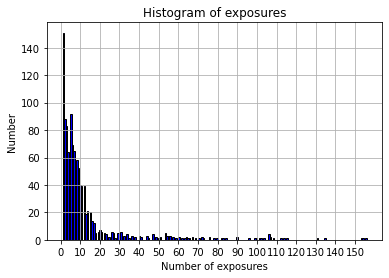

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
#This is nubmer of exposures for each objects
nume = desjt.groupby('Principal_desig').size()
#plot histogram for that.
plt.hist(nume, color = 'blue', edgecolor = 'black',bins = 200)
plt.title('Histogram of exposures')
plt.xlabel('Number of exposures')
plt.ylabel('Number')
plt.xticks(np.arange(0, max(nume), 10.0))
plt.grid()
#np.average(nume[nume<20])
len(nume[nume>20])
#Looks to have many JTs with 6 exposures.
#Many JTs with > 20 exposures 

In [21]:
len(nume[nume==1])

151

In [22]:
len(nume[nume>20])

144

In [140]:
nume

Principal_desig
1971 FF     20
1973 UF5     2
1975 QD     35
1983 PV      3
1985 VO      2
            ..
2021 KL4     8
2021 LR4     1
3365 T-3     2
4101 T-3    11
5191 T-3     5
Length: 1088, dtype: int64

In [141]:
aa = nume[nume<2]

In [ ]:
# now add bands and time to the table of Jrojans.
a = despo[['EXPNUM','DATE_OBS','BAND']].values.tolist()
for i in a:
    expnum = i[0]
    desjt.loc[desjt['expnum'] == expnum, 'BAND'] = i[2]
    desjt.loc[desjt['expnum'] == expnum, 'DATE_OBS'] = i[1]

In [ ]:
#desjt.to_csv('DES_Trojans_mpc.csv', index=None)
desjt

### Plot band per objects

86

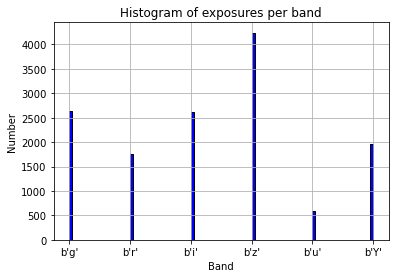

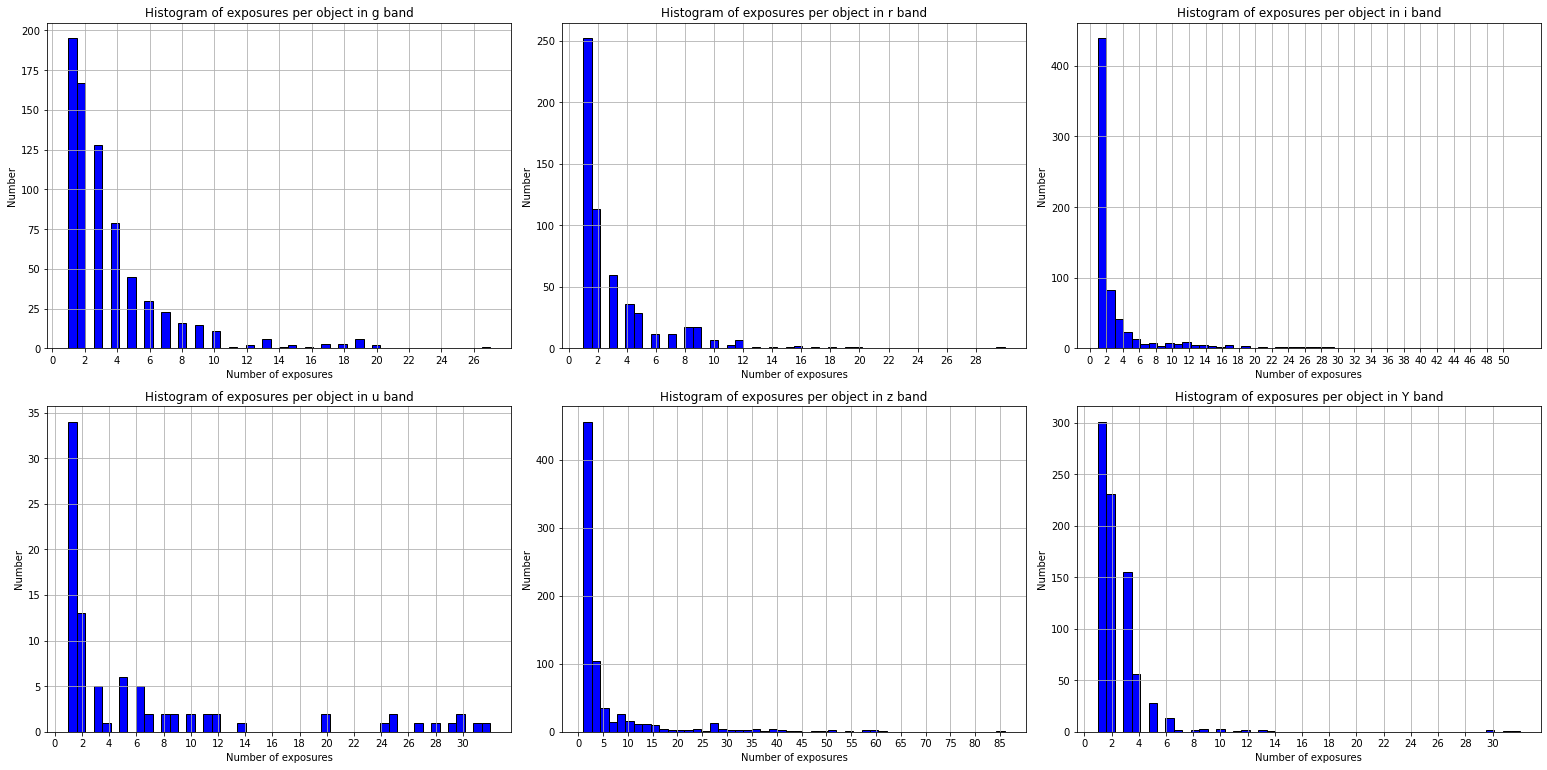

In [23]:
desjt = pd.read_csv('DES_Trojans_mpc.csv')
bande = desjt.groupby('BAND').size()
#plot histogram for that.
plt.figure(figsize=(6,4),frameon=False)
plt.hist(desjt['BAND'], color = 'blue', edgecolor = 'black',bins = 100)
plt.title('Histogram of exposures per band')
plt.xlabel('Band')
plt.ylabel('Number')
plt.grid()

plt.figure(figsize=(18*1.2,9*1.2),frameon=False)
ax2=plt.subplot(231)
gband = desjt.loc[desjt['BAND']=="b'g'"]
nume = gband.groupby('Principal_desig').size()
plt.hist(nume, color = 'blue', edgecolor = 'black',bins = 50)
plt.title('Histogram of exposures per object in g band')
plt.xlabel('Number of exposures')
plt.ylabel('Number')
plt.xticks(np.arange(0, max(nume), 2.0))
plt.grid()

ax2=plt.subplot(232)
rband = desjt.loc[desjt['BAND']=="b'r'"]
nume = rband.groupby('Principal_desig').size()
plt.hist(nume, color = 'blue', edgecolor = 'black',bins = 50)
plt.title('Histogram of exposures per object in r band')
plt.xlabel('Number of exposures')
plt.ylabel('Number')
plt.xticks(np.arange(0, max(nume), 2.0))
plt.grid()

ax2=plt.subplot(233)
iband = desjt.loc[desjt['BAND']=="b'i'"]
nume = iband.groupby('Principal_desig').size()
plt.hist(nume, color = 'blue', edgecolor = 'black',bins = 50)
plt.title('Histogram of exposures per object in i band')
plt.xlabel('Number of exposures')
plt.ylabel('Number')
plt.xticks(np.arange(0, max(nume), 2.0))
plt.grid()

ax2=plt.subplot(234)
uband = desjt.loc[desjt['BAND']=="b'u'"]
nume = uband.groupby('Principal_desig').size()
plt.hist(nume, color = 'blue', edgecolor = 'black',bins = 50)
plt.title('Histogram of exposures per object in u band')
plt.xlabel('Number of exposures')
plt.ylabel('Number')
plt.xticks(np.arange(0, max(nume), 2.0))
plt.grid()

ax2=plt.subplot(235)
Yband = desjt.loc[desjt['BAND']=="b'z'"]
nume = Yband.groupby('Principal_desig').size()
plt.hist(nume, color = 'blue', edgecolor = 'black',bins = 50)
plt.title('Histogram of exposures per object in z band')
plt.xlabel('Number of exposures')
plt.ylabel('Number')
plt.xticks(np.arange(0, max(nume), 5.0))
plt.grid()
plt.tight_layout()

ax2=plt.subplot(236)
Yband = desjt.loc[desjt['BAND']=="b'Y'"]
nume = Yband.groupby('Principal_desig').size()
plt.hist(nume, color = 'blue', edgecolor = 'black',bins = 50)
plt.title('Histogram of exposures per object in Y band')
plt.xlabel('Number of exposures')
plt.ylabel('Number')
plt.xticks(np.arange(0, max(nume), 2.0))
plt.grid()
plt.tight_layout()

Yband = desjt.loc[desjt['BAND']=="b'z'"]
nume = Yband.groupby('Principal_desig').size()
max(nume)

Now find objects that can be plotted as g - r, r - i or z - i

In [24]:
goodg = desjt.loc[(desjt['RA_3sigma']<2)&(desjt['DEC_3sigma']<2)&(desjt['BAND']=="b'g'")]['Principal_desig'].unique()
goodr = desjt.loc[(desjt['RA_3sigma']<2)&(desjt['DEC_3sigma']<2)&(desjt['BAND']=="b'r'")]['Principal_desig'].unique()
goodi = desjt.loc[(desjt['RA_3sigma']<2)&(desjt['DEC_3sigma']<2)&(desjt['BAND']=="b'i'")]['Principal_desig'].unique()
goodz = desjt.loc[(desjt['RA_3sigma']<2)&(desjt['DEC_3sigma']<2)&(desjt['BAND']=="b'z'")]['Principal_desig'].unique()
goodu = desjt.loc[(desjt['RA_3sigma']<2)&(desjt['DEC_3sigma']<2)&(desjt['BAND']=="b'u'")]['Principal_desig'].unique()
print(len(goodg))
print(len(goodr))
print(len(goodi))
print(len(goodz))
print(len(goodu))

654
509
606
659
82


g-r 464
r-i 458
z-i 525
u-g 19
z-r 417
z-g 490
g-r&r-i 423
g-r&z-i 366
r-i&z-i 396
g-r&z-g 382
g-r&z-r 382


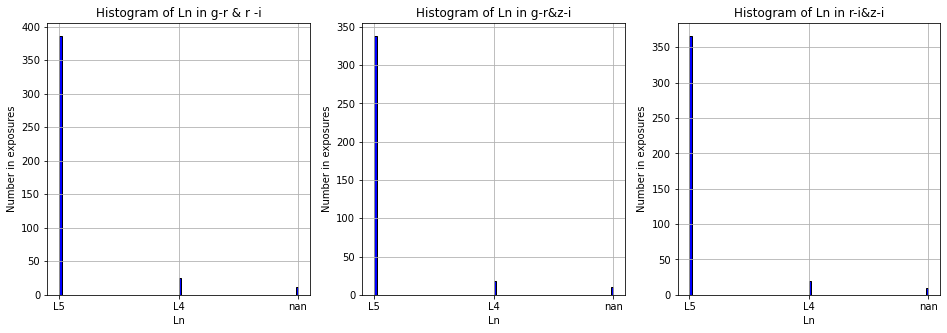

In [5]:
grgood = []
for i in goodg:
    for a in goodr:
        if i == a: 
            grgood.append(i)
print('g-r',len(grgood))

rigood = []
for i in goodi:
    for a in goodr:
        if i == a: 
            rigood.append(i)
print('r-i',len(rigood))

zigood = []
for i in goodz:
    for a in goodi:
        if i == a: 
            zigood.append(i)
print('z-i',len(zigood))

uggood = []
for i in goodu:
    for a in goodg:
        if i == a: 
            uggood.append(i)
print('u-g',len(uggood))

zrgood = []
for i in goodz:
    for a in goodr:
        if i == a: 
            zrgood.append(i)
print('z-r',len(zrgood))

zggood = []
for i in goodz:
    for a in goodg:
        if i == a: 
            zggood.append(i)
print('z-g',len(zggood))

grrigood = []
for i in grgood:
    for a in rigood:
        if i == a: 
            grrigood.append(i)
LL = []
for b in grrigood:
    l = desjt.loc[desjt['Principal_desig'] == b]['Ln'].unique()
    l = l[0]
    LL.append(l)
#print(LL)
print('g-r&r-i',len(grrigood))
plt.figure(figsize=(16,5),frameon=False)
ax2=plt.subplot(131)
plt.hist(LL, color = 'blue', edgecolor = 'black',bins = 100)
plt.title('Histogram of Ln in g-r & r -i')
plt.xlabel('Ln')
plt.ylabel('Number in exposures')
plt.grid()

grzigood = []
for i in grgood:
    for a in zigood:
        if i == a: 
            grzigood.append(i)
print('g-r&z-i',len(grzigood))
LL = []
for b in grzigood:
    l = desjt.loc[desjt['Principal_desig'] == b]['Ln'].unique()
    l = l[0]
    LL.append(l)
ax2=plt.subplot(132)
plt.hist(LL, color = 'blue', edgecolor = 'black',bins = 100)
plt.title('Histogram of Ln in g-r&z-i')
plt.xlabel('Ln')
plt.ylabel('Number in exposures')
plt.grid()

rizigood = []
for i in rigood:
    for a in zigood:
        if i == a: 
            rizigood.append(i)
print('r-i&z-i',len(rizigood))
LL = []
for b in rizigood:
    l = desjt.loc[desjt['Principal_desig'] == b]['Ln'].unique()
    l = l[0]
    LL.append(l)
ax2=plt.subplot(133)
plt.hist(LL, color = 'blue', edgecolor = 'black',bins = 100)
plt.title('Histogram of Ln in r-i&z-i')
plt.xlabel('Ln')
plt.ylabel('Number in exposures')
plt.grid()

grzggood = []
for i in grgood:
    for a in zggood:
        if i == a: 
            grzggood.append(i)
print('g-r&z-g',len(grzggood))

grzrgood = []
for i in grgood:
    for a in zrgood:
        if i == a: 
            grzrgood.append(i)
print('g-r&z-r',len(grzrgood))

In [33]:
#grzigood
for i in desjt:
    print(i)

expnum
Principal_desig
ra
dec
ccd
BAND
DATE_OBS
U
RA_3sigma
DEC_3sigma
Ln


In [29]:
# Store some good JTs
goodjt = pd.DataFrame()
goo = []
desjj = desjt.values.tolist()
for i in desjj:
    najt = i[1]
    for j in grzigood:

        if najt == j:
            goo.append(i)
#print(goodjt)
#goodjt[['']]
#print(goo)

In [41]:
goodjt = pd.DataFrame()
exp = []
na =[]
ra=[]
dec=[]
ccd=[]
Band = []
date = []
U = []
delra = []
deldec = []
L = []
for i in goo:
    exp.append(i[0])
    na.append(i[1])
    ra.append(i[2])
    dec.append(i[3])
    ccd.append(i[4])
    Band.append(i[5])
    date.append(i[6])
    U.append(i[7])
    delra.append(i[8])
    deldec.append(i[9])
    L.append(i[10])

In [35]:
#print(len(goo))
goodjt['expnum','Principal_desig','ra','dec','ccd','BAND','DATE_OBS','U'
,'RA_3sigma'
,'DEC_3sigma'
,'Ln'] = goo
goodjt

8632


TypeError: list indices must be integers or slices, not tuple

In [43]:
goodjt['expnum'] = exp
goodjt['Principal_desig'] =na
goodjt['ra'] = ra
goodjt['dec']=dec
goodjt['ccd']=ccd
goodjt['BAND']=Band
goodjt['DATE_OBS']=date
goodjt['U']=U
goodjt['RA_3sigma']=delra
goodjt['DEC_3sigma']=deldec
goodjt['Ln']=L

goodjt
len(goodjt['Principal_desig'].unique())

366

In [44]:
goodjt.to_csv('DES_GoodTrojans_mpc.csv', index=None)

### check the two JTs overlapping with DEEP: 2002 CH326 and 2014 UQ194
Both are captued in all band of g, r, i, and z. 2002 CH326 also has u band.

In [6]:
if '2014 UQ194' in str(zigood):
    print('True')
else:
        print('No') 

if '2002 CH326' in str(zigood):
    print('True')
else:
        print('No')
if '2014 UQ194' in str(grgood):
    print('True')
else:
        print('No')    
if '2002 CH326' in str(grgood):
    print('True')
else:
        print('No')

if '2014 UQ194' in str(rigood):
    print('True')
else:
        print('No')    
if '2002 CH326' in str(rigood):
    print('True')
else:
        print('No')
        
if '2014 UQ194' in str(zrgood):
    print('True')
else:
        print('No')    
if '2002 CH326' in str(zrgood):
    print('True')
else:
        print('No')

    
if '2014 UQ194' in str(zggood):
    print('True')
else:
        print('No')    
if '2002 CH326' in str(zggood):
    print('True')
else:
        print('No')
        
if '2014 UQ194' in str(uggood):
    print('True')
else:
        print('No')    
if '2002 CH326' in str(uggood):
    print('True')
else:
        print('No')
print(uggood)

True
True
True
True
True
True
True
True
True
True
No
True
['2008 SY169', '2008 SB232', '2010 HU58', '1999 RQ116', '1988 RY11', '2008 SA164', '2002 ET8', '2003 HN24', '2009 SS246', '2010 BH62', '2002 CH326', '2013 CK135', '2013 CX167', '2013 CK222', '2013 CH223', '2013 CC222', '2009 SN122', '2008 EK137', '2007 ET239']


### Now plot u uncertainty from MPC

In [116]:
dfo = pd.read_csv('mpcorb_extended.csv')

In [127]:
# u value does not change with time.
df = dfo.loc[dfo.Orbit_type=="Jupiter Trojan"]
b = df.values.tolist()
#for i in df:
#    print(i)

H
G
Num_obs
rms
U
Arc_years
Perturbers
Perturbers_2
Number
Name
Principal_desig
Other_desigs
Epoch
M
Peri
Node
i
e
n
a
Ref
Num_opps
Computer
Hex_flags
Last_obs
Tp
Orbital_period
Perihelion_dist
Aphelion_dist
Semilatus_rectum
Synodic_period
Orbit_type
NEO_flag
One_km_NEO_flag
PHA_flag
Critical_list_numbered_object_flag
One_opposition_object_flag
Arc_length


In [128]:
b[0][10]

'A906 DN'

In [129]:
desjt = pd.read_csv('DES_Trojans_mpc.csv')
for i in b:
    U = i[4]
    sig = i[10]
    desjt.loc[desjt['Principal_desig'] == sig, 'U'] = U
desjt
desjt.to_csv('DES_Trojans_mpc.csv', index=None)

,expnum,Principal_desig,ra,dec,ccd,BAND,DATE_OBS,U
0,157460,2001 XO128,34.570048,-5.635341,58,b'g',b'2012-12-03T01:54:00.378837',0
1,157460,2020 HS92,34.224163,-5.320325,47,b'g',b'2012-12-03T01:54:00.378837',5
2,157461,2001 XO128,34.569808,-5.635227,58,b'r',b'2012-12-03T01:57:23.095488',0
3,157461,2020 HS92,34.223969,-5.320304,47,b'r',b'2012-12-03T01:57:23.095488',5
4,157462,2001 XO128,34.569596,-5.635126,58,b'i',b'2012-12-03T02:00:22.145094',0
...,...,...,...,...,...,...,...,...
13770,397707,2006 AN97,35.770972,-4.227069,13,b'g',b'2015-01-14T01:03:29.030379',0
13771,397707,2006 BH185,36.941394,-4.456668,30,b'g',b'2015-01-14T01:03:29.030379',0
13772,397708,2006 AN97,35.771034,-4.226834,13,b'g',b'2015-01-14T01:07:16.506021',0
13773,397708,2006 BH185,36.941465,-4.456469,30,b'g',b'2015-01-14T01:07:16.506021',0


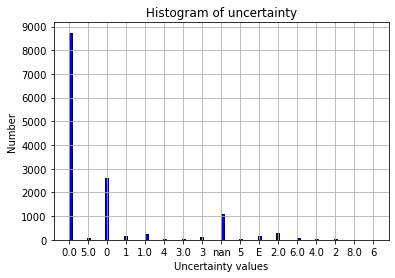

In [149]:
desjt = pd.read_csv('DES_Trojans_mpc.csv')
u = desjt['U'].values.tolist()
plt.hist(u, color = 'blue', edgecolor = 'black',bins = 100)
plt.title('Histogram of uncertainty')
plt.xlabel('Uncertainty values')
plt.ylabel('Number')
plt.yticks(np.arange(0, 10000, 1000.0))
plt.grid()
#len(u[u<2])
#About > 11000 smaller than 2 u uncertainty. Good.

In [144]:
desjt

,expnum,Principal_desig,ra,dec,ccd,BAND,DATE_OBS,U
0,157460,2001 XO128,34.570048,-5.635341,58,b'g',b'2012-12-03T01:54:00.378837',0
1,157460,2020 HS92,34.224163,-5.320325,47,b'g',b'2012-12-03T01:54:00.378837',5
2,157461,2001 XO128,34.569808,-5.635227,58,b'r',b'2012-12-03T01:57:23.095488',0
3,157461,2020 HS92,34.223969,-5.320304,47,b'r',b'2012-12-03T01:57:23.095488',5
4,157462,2001 XO128,34.569596,-5.635126,58,b'i',b'2012-12-03T02:00:22.145094',0
...,...,...,...,...,...,...,...,...
13770,397707,2006 AN97,35.770972,-4.227069,13,b'g',b'2015-01-14T01:03:29.030379',0
13771,397707,2006 BH185,36.941394,-4.456668,30,b'g',b'2015-01-14T01:03:29.030379',0
13772,397708,2006 AN97,35.771034,-4.226834,13,b'g',b'2015-01-14T01:07:16.506021',0
13773,397708,2006 BH185,36.941465,-4.456469,30,b'g',b'2015-01-14T01:07:16.506021',0


### Now use JPL Horizon to calcualte real uncertainty
Will do it on Jupyterbook (not on moriarty)

In [1]:
#pip install astroquery

     |████████████████████████████████| 3.9 MB 13.8 MB/s eta 0:00:01
     |████████████████████████████████| 802 kB 164.6 MB/s eta 0:00:01
  Created wheel for mimeparse: filename=mimeparse-0.1.3-py3-none-any.whl size=3863 sha256=39932e31aa0b5cb35a80d06a77e6c8cee7172c539765da811a7f1e943acb8011
  Stored in directory: /home/jiamingp/.cache/pip/wheels/10/4a/42/2f6bad162811fe51b5e3f250cb31c88e0d362b23e873380815
Successfully built mimeparse
Note: you may need to restart the kernel to use updated packages.


In [16]:
from astroquery.jplhorizons import Horizons
from astropy.time import Time
starttime = Time('2012-12-03 01:54:00.37', format='iso', scale='utc')
stoptime = starttime + 1*u.minute
obj = Horizons(id='2001 XO128', location='W84',
                epochs={'start':'2012-12-03 01:54:00.37', 'stop':'2012-12-03 01:56:00.37',
                        'step':'1m'})

### Separate JTs with L4 and L5

In [34]:
JT = pd.read_csv('DES JTs/List of Jupiter Trojans.csv')
desjt = pd.read_csv('DES JTs/DES_Trojans_mpc.csv')

In [20]:
desjt

,expnum,Principal_desig,ra,dec,ccd,BAND,DATE_OBS,U,RA_3sigma,DEC_3sigma
0,157460,2001 XO128,34.570048,-5.635341,58,b'g',b'2012-12-03T01:54:00.378837',0.0,RA_3sigma\n arcsec \n---------\n 0.102,DEC_3sigma\n arcsec \n----------\n 0.09
1,157460,2020 HS92,34.224163,-5.320325,47,b'g',b'2012-12-03T01:54:00.378837',5.0,RA_3sigma\n arcsec \n---------\n 24.284,DEC_3sigma\n arcsec \n----------\n 6.103
2,157461,2001 XO128,34.569808,-5.635227,58,b'r',b'2012-12-03T01:57:23.095488',0.0,RA_3sigma\n arcsec \n---------\n 0.102,DEC_3sigma\n arcsec \n----------\n 0.09
3,157461,2020 HS92,34.223969,-5.320304,47,b'r',b'2012-12-03T01:57:23.095488',5.0,RA_3sigma\n arcsec \n---------\n 24.284,DEC_3sigma\n arcsec \n----------\n 6.103
4,157462,2001 XO128,34.569596,-5.635126,58,b'i',b'2012-12-03T02:00:22.145094',0.0,RA_3sigma\n arcsec \n---------\n 0.102,DEC_3sigma\n arcsec \n----------\n 0.09
...,...,...,...,...,...,...,...,...,...,...
13770,397707,2006 AN97,35.770972,-4.227069,13,b'g',b'2015-01-14T01:03:29.030379',0.0,RA_3sigma\n arcsec \n---------\n 0.172,DEC_3sigma\n arcsec \n----------\n 0.096
13771,397707,2006 BH185,36.941394,-4.456668,30,b'g',b'2015-01-14T01:03:29.030379',0.0,RA_3sigma\n arcsec \n---------\n 0.195,DEC_3sigma\n arcsec \n----------\n 0.104
13772,397708,2006 AN97,35.771034,-4.226834,13,b'g',b'2015-01-14T01:07:16.506021',0.0,RA_3sigma\n arcsec \n---------\n 0.172,DEC_3sigma\n arcsec \n----------\n 0.096
13773,397708,2006 BH185,36.941465,-4.456469,30,b'g',b'2015-01-14T01:07:16.506021',0.0,RA_3sigma\n arcsec \n---------\n 0.195,DEC_3sigma\n arcsec \n----------\n 0.104


In [34]:
a = JT.values.tolist()

for i in a:
    name = i[4]
    Ln = i[5]
    desjt.loc[desjt['Principal_desig'] == name, 'Ln'] = Ln

In [25]:
len(desjt.loc[desjt['Ln']=='L5'])

11113

In [62]:
len(desjt.loc[desjt['Ln']=='L4'])

2277

In [27]:
len(desjt)

13775

In [35]:
desjt

,expnum,Principal_desig,ra,dec,ccd,BAND,DATE_OBS,U,RA_3sigma,DEC_3sigma,Ln
0,157460,2001 XO128,34.570048,-5.635341,58,b'g',b'2012-12-03T01:54:00.378837',0.0,RA_3sigma\n arcsec \n---------\n 0.102,DEC_3sigma\n arcsec \n----------\n 0.09,L5
1,157460,2020 HS92,34.224163,-5.320325,47,b'g',b'2012-12-03T01:54:00.378837',5.0,RA_3sigma\n arcsec \n---------\n 24.284,DEC_3sigma\n arcsec \n----------\n 6.103,L5
2,157461,2001 XO128,34.569808,-5.635227,58,b'r',b'2012-12-03T01:57:23.095488',0.0,RA_3sigma\n arcsec \n---------\n 0.102,DEC_3sigma\n arcsec \n----------\n 0.09,L5
3,157461,2020 HS92,34.223969,-5.320304,47,b'r',b'2012-12-03T01:57:23.095488',5.0,RA_3sigma\n arcsec \n---------\n 24.284,DEC_3sigma\n arcsec \n----------\n 6.103,L5
4,157462,2001 XO128,34.569596,-5.635126,58,b'i',b'2012-12-03T02:00:22.145094',0.0,RA_3sigma\n arcsec \n---------\n 0.102,DEC_3sigma\n arcsec \n----------\n 0.09,L5
...,...,...,...,...,...,...,...,...,...,...,...
13770,397707,2006 AN97,35.770972,-4.227069,13,b'g',b'2015-01-14T01:03:29.030379',0.0,RA_3sigma\n arcsec \n---------\n 0.172,DEC_3sigma\n arcsec \n----------\n 0.096,L5
13771,397707,2006 BH185,36.941394,-4.456668,30,b'g',b'2015-01-14T01:03:29.030379',0.0,RA_3sigma\n arcsec \n---------\n 0.195,DEC_3sigma\n arcsec \n----------\n 0.104,L5
13772,397708,2006 AN97,35.771034,-4.226834,13,b'g',b'2015-01-14T01:07:16.506021',0.0,RA_3sigma\n arcsec \n---------\n 0.172,DEC_3sigma\n arcsec \n----------\n 0.096,L5
13773,397708,2006 BH185,36.941465,-4.456469,30,b'g',b'2015-01-14T01:07:16.506021',0.0,RA_3sigma\n arcsec \n---------\n 0.195,DEC_3sigma\n arcsec \n----------\n 0.104,L5


In [ ]:
desjt.to_csv('DES_Trojans_mpc.csv', index=None)

In [42]:
#desjt[['Principal_desig','Ln']]
L4 = desjt.loc[desjt['Ln']=="L4"]
nume = L4.groupby('Principal_desig').size()


Principal_desig
1973 UF5        2
1983 PV         3
1985 VO         2
1989 CK1       20
1996 RT29       1
             ... 
2020 QG72     131
2020 RQ107      1
2020 SS69       3
2020 ST70       1
2020 SX64       8
Length: 126, dtype: int64

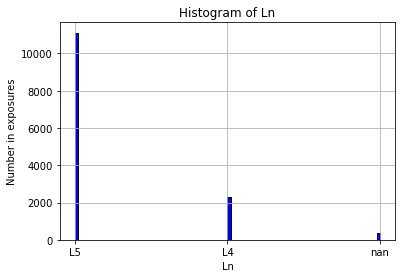

In [55]:
l = desjt['Ln'].values.tolist()
plt.hist(l, color = 'blue', edgecolor = 'black',bins = 100)
plt.title('Histogram of Ln')
plt.xlabel('Ln')
plt.ylabel('Number in exposures')
plt.grid()
# L5 11113
# L4 2277
# 385 nan

In [67]:
num = desjt['Principal_desig'].unique()
len(num)

1088

In [33]:
# Now for each object
a = JT.values.tolist()
lobj = []
def give_Ln(name):
    for n in a:
        na = n[4]
        Ln = n[5]
        if na == name:
            return Ln
            
for i in num:
    Ln = give_Ln(i)
    if isinstance(Ln, basestring) == True:
        lobj.append(Ln)

NameError: name 'JT' is not defined

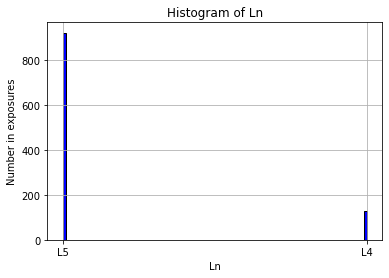

In [86]:
plt.hist(lobj, color = 'blue', edgecolor = 'black',bins = 100)
plt.title('Histogram of Ln')
plt.xlabel('Ln')
plt.ylabel('Number in exposures')
plt.grid()

In [87]:
len(lobj)

1048

In [90]:
len(lobj[lobj=='L5'])

2

In [128]:
desjt = pd.read_csv('DES JTs/DES_Trojans_mpc (3).csv')

In [129]:
desjt

,expnum,Principal_desig,ra,dec,ccd,BAND,DATE_OBS,U,RA_3sigma,DEC_3sigma,Ln
0,157460,2001 XO128,34.570048,-5.635341,58,b'g',b'2012-12-03T01:54:00.378837',0.0,0.102,0.090,L5
1,157460,2020 HS92,34.224163,-5.320325,47,b'g',b'2012-12-03T01:54:00.378837',5.0,24.284,6.103,L5
2,157461,2001 XO128,34.569808,-5.635227,58,b'r',b'2012-12-03T01:57:23.095488',0.0,0.102,0.090,L5
3,157461,2020 HS92,34.223969,-5.320304,47,b'r',b'2012-12-03T01:57:23.095488',5.0,24.284,6.103,L5
4,157462,2001 XO128,34.569596,-5.635126,58,b'i',b'2012-12-03T02:00:22.145094',0.0,0.102,0.090,L5
...,...,...,...,...,...,...,...,...,...,...,...
13770,397707,2006 AN97,35.770972,-4.227069,13,b'g',b'2015-01-14T01:03:29.030379',0.0,0.172,0.096,L5
13771,397707,2006 BH185,36.941394,-4.456668,30,b'g',b'2015-01-14T01:03:29.030379',0.0,0.195,0.104,L5
13772,397708,2006 AN97,35.771034,-4.226834,13,b'g',b'2015-01-14T01:07:16.506021',0.0,0.172,0.096,L5
13773,397708,2006 BH185,36.941465,-4.456469,30,b'g',b'2015-01-14T01:07:16.506021',0.0,0.195,0.104,L5


In [10]:
goodna = desjt.loc[(desjt['RA_3sigma']<2)&(desjt['DEC_3sigma']<2)]['Principal_desig'].unique()
len(goodna)

964

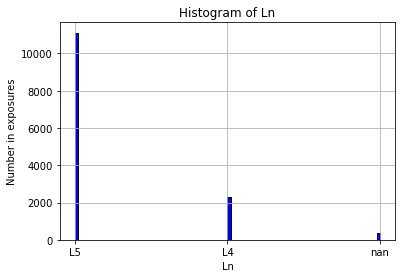

In [31]:
l = desjt['Ln'].values.tolist()
plt.hist(l, color = 'blue', edgecolor = 'black',bins = 100)
plt.title('Histogram of Ln')
plt.xlabel('Ln')
plt.ylabel('Number in exposures')
plt.grid()

In [36]:
lobj = []
a = JT.values.tolist()
def give_Ln(name):
    for n in a:
        na = n[4]
        Ln = n[5]
        if na == name:
            return Ln
            
for i in goodna:
    Ln = give_Ln(i)
    if isinstance(Ln, basestring) == True:
        lobj.append(Ln)

946

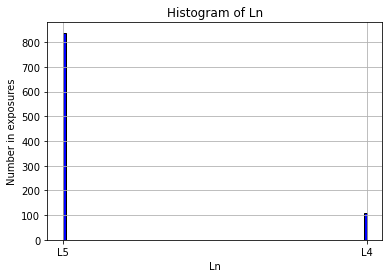

In [101]:
plt.hist(lobj, color = 'blue', edgecolor = 'black',bins = 100)
plt.title('Histogram of Ln')
plt.xlabel('Ln')
plt.ylabel('Number in exposures')
plt.grid()
len(lobj) #18 nan 

In [39]:
aa

Principal_desig
1988 RE12     1
1988 RL13     1
1995 CV       1
1996 RT29     1
1996 TY68     1
             ..
2020 HJ99     1
2020 RQ107    1
2020 ST70     1
2021 GN101    1
2021 GZ63     1
Length: 119, dtype: int64

In [104]:
print(lobj.count('L5'))
print(lobj.count('L4'))

838
108


In [45]:
bb = []
for i in goodna:
    if i == '2020 ST70':
        bb.append(i)
bb
    

[]

In [6]:
desjt.groupby('Principal_desig').Principal_desig.count() <2

Principal_desig
1971 FF     False
1973 UF5    False
1975 QD     False
1983 PV     False
1985 VO     False
            ...  
2021 KL4    False
2021 LR4     True
3365 T-3    False
4101 T-3    False
5191 T-3    False
Name: Principal_desig, Length: 1088, dtype: bool

In [7]:
a = desjt.loc[desjt['Principal_desig']=='1995 CV']['ra'].count()
a

8

In [8]:
a = desjt.values.tolist()
badnum = []
for i in a:
    na = i[1]
  #  print(na)
    if desjt.loc[desjt['Principal_desig']==na]['expnum'].count() == 1:
        badnum.append(na)
#badnum

In [9]:
len(badnum)

151

In [136]:
desjt = pd.read_csv('DES JTs/DES_Trojans_mpc (3).csv')
nume = desjt.groupby('Principal_desig').size()
len(nume[nume==1])
nume[nume==1]
desjt.to_csv('DES_Trojans_mpc.csv', index=None)

In [135]:
desjt = pd.read_csv('DES_Trojans_mpc.csv')
nume = desjt.groupby('Principal_desig').size()
len(nume[nume==1])
nume[nume==1]

Principal_desig
1988 RE12     1
1988 RL13     1
1995 CV       1
1996 RT29     1
1996 TY68     1
             ..
2020 HJ99     1
2020 RQ107    1
2020 ST70     1
2021 GN101    1
2021 GZ63     1
Length: 119, dtype: int64

In [11]:
bb = []

for i in goodna:
    for b in badnum:
        if i == b:
            bb.append(i)
bb

['2010 BM90',
 '2010 XF85',
 '2013 CF115',
 '1988 RE12',
 '2008 KH35',
 '2012 TJ25',
 '2008 KV8',
 '2010 VS',
 '2013 TH32',
 '2012 TP52',
 '2012 TS256',
 '2000 SJ49',
 '2000 SL47',
 '2011 LA20',
 '2000 SA97',
 '2005 XS92',
 '2011 QW53',
 '2006 DB20',
 '2012 PK44',
 '2018 AV40',
 '2011 OT5',
 '2006 BG203',
 '2015 XR446',
 '2000 SB132',
 '2006 EP74',
 '2015 AY259',
 '2008 HL75',
 '2016 CU31',
 '2017 DG116',
 '2011 QB108',
 '2001 WB53',
 '2008 KY36',
 '2012 TY122',
 '2017 DD21',
 '2000 SA89',
 '2016 AW60',
 '2001 VK85',
 '2011 QV76',
 '2005 EQ272',
 '2011 KT21',
 '2014 WB18',
 '2011 KG17',
 '2014 VF8',
 '2002 CB94',
 '1996 TY68',
 '1999 WB2',
 '2013 CJ194',
 '2009 UE72',
 '2000 XN9',
 '2003 JG8',
 '2003 HQ35',
 '2008 SE276',
 '2009 UX143',
 '2013 AF',
 '2008 RQ175',
 '2009 VG58',
 '1999 YC13',
 '2013 FM1',
 '2001 CN33',
 '2009 WU112',
 '1996 RT29',
 '2006 BZ55',
 '2008 FQ132',
 '2000 SK47',
 '2000 QN116',
 '2007 EO34',
 '2014 WB546',
 '2009 FB63',
 '2004 YD23',
 '2016 AD303',
 '2001 RH142

In [12]:
len(bb)

125

In [16]:
goodna[goodna=='2011 OJ63']
#So there are many one exposures in the very accuarte measured JTs. Would make the good nubmer go down by 125
#964 - 125 = 839
# Probably eventually have 700 or so good enough JTs....

array(['2011 OJ63'], dtype=object)

### Distinguish all L4 and L5 JTs

In [30]:
desjt = pd.read_csv('DES_Trojans_mpc.csv')
len(desjt.loc[(desjt['Ln']!='L5')&(desjt['Ln']!='L4')]['DATE_OBS'].unique())
nandate = desjt.loc[(desjt['Ln']!='L5')&(desjt['Ln']!='L4')]['DATE_OBS'].unique()
nanna = desjt.loc[(desjt['Ln']!='L5')&(desjt['Ln']!='L4')]['Principal_desig'].unique()
print(len(nandate))
print(len(nanna))
#print(nandate)

378
40


In [33]:
# First only leave jupiter trojans in the list.
dfjt = pd.read_csv('mpcorb_JT.csv')
jtname = dfjt['Principal_desig']
jtname = jtname.values.tolist()
#Now select the list of trojans with the name in this list.
cc = pd.DataFrame()
for i in jtname:
    jtn = desjt.loc[desjt['Principal_desig']==i]
    cc = pd.concat([cc,jtn])
print(cc)

       expnum Principal_desig          ra       dec  ccd  BAND  \
325    398230         1971 FF   33.360533  4.091682   51  b'z'   
327    398232         1971 FF   33.360668  4.091818   21  b'z'   
2542   229724         1971 FF    8.352986 -3.065867   47  b'g'   
2812   231945         1971 FF    7.702020 -3.504681    5  b'g'   
3151   233119         1971 FF    7.399927 -3.696635   37  b'Y'   
...       ...             ...         ...       ...  ...   ...   
6052   243514       2019 GH23    1.635546  0.945336   46  b'i'   
8934   257225       2019 GH23  358.915776 -0.080070   30  b'g'   
8988   257259       2019 GH23  358.915045 -0.080159   30  b'z'   
9116   257466       2019 GH23  358.905774 -0.081153   33  b'r'   
10442  262940       2019 GH23  359.317899  0.152033   51  b'Y'   

                            DATE_OBS    U    RA_3sigma   DEC_3sigma  Ln  
325    b'2015-01-15T01:12:19.639544'  0.0        0.085        0.052  L5  
327    b'2015-01-15T01:17:01.220886'  0.0        0.085     

In [35]:
cc['Principal_desig'].unique()
len(cc['Principal_desig'].unique())
cc.loc[cc['Principal_desig']=='2010 WH38']
cc.to_csv('DES_Trojans_mpc(2).csv', index=None)

In [9]:
rocks = SpaceRock(a='5.204', 
                  e='0.0489', 
                  inc='1.303', 
                  arg='273.867', 
              #    node=df.Node.values, 
                #  t_peri=df.Tp.values, 
               #   epoch=df.Epoch.values,
              #    H=df.H.values, 
                  name='Jupiter',
                  precise=False,
                  coordinates='keplerian',
                  angles='degrees',
                  frame='heliocentric',
                  obscode='W84')
dates = Time('2015-01-16 01:30:48.578356', format='iso', scale='utc')
prop1 = rocks.propagate(dates.jd, model=2)
obs1o = prop1.observe('W84')
print(obs1o.ra.deg)
print(obs1o.dec.deg )

ValueError: Invalid input coordinates. Please see the documentation for accepted input.